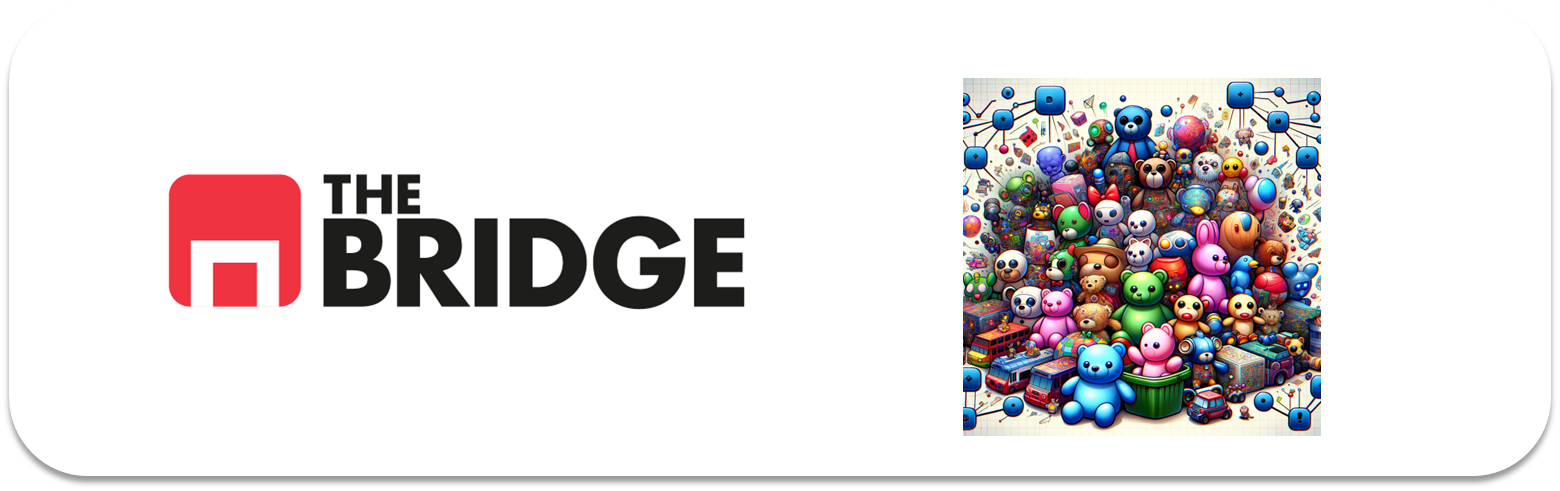

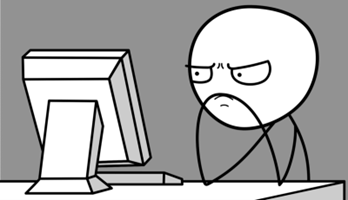

Para ejercitarte y afianzar lo aprendido sobre **K-Means**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [56]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples
from sklearn.preprocessing import MinMaxScaler

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

### Entendiendo el problema de negocio

En este notebook vamos a hacer un análisis de datos tirando de clusterizaciones para evaluar si existen grupos en nuestros productos, en este caso medicamentos, y posteriormente poder etiquetarlos. Poseemos información como rating, efectividad, efectos secundarios, entre otros.

### Ejercicio 1

Importa los datos, "./data/drugLibTrain_raw.tsv", que contiene un dataset con diferentes fármacos, sus efectos y ratings de los clientes de dichos fármacos. Realiza una inspección preliminar y quita las columnas que consideres innecesarias.

In [57]:
df_drugs = pd.read_csv('data/drugLibTrain_raw.tsv', sep = '\t')
df_drugs.head(5)

,Unnamed: 0,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
0,2202,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ..."
1,3117,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest..."
2,1146,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...
3,3947,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",I was given Prilosec prescription at a dose of...
4,1951,lyrica,2,Marginally Effective,Severe Side Effects,fibromyalgia,I think that the Lyrica was starting to help w...,I felt extremely drugged and dopey. Could not...,See above


In [58]:
df_drugs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3107 entries, 0 to 3106
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         3107 non-null   int64 
 1   urlDrugName        3107 non-null   object
 2   rating             3107 non-null   int64 
 3   effectiveness      3107 non-null   object
 4   sideEffects        3107 non-null   object
 5   condition          3106 non-null   object
 6   benefitsReview     3089 non-null   object
 7   sideEffectsReview  3032 non-null   object
 8   commentsReview     3095 non-null   object
dtypes: int64(2), object(7)
memory usage: 218.6+ KB


In [59]:
df_drugs.drop(columns= 'Unnamed: 0', inplace= True)

### Ejercicio 2: MiniEDA

Como es un problema no supervisado (vamos a intentar agrupar los medicamentos sin tener una referencia o target inicial), no hay split, vamos directos al miniEDA. Analiza qué variables son descartables en función de su porcentaje de cardinalidad. Es decir obten la cardinalidad y su porcentaje para cada posible feature y crea un dataset nuevo descartando las features que creas conveniente. NOTA: Como simplificación, descarta la columna con url.

In [60]:
df_drugs.describe(include= 'all')

,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
count,3107,3107.000000,3107,3107,3106,3089,3032,3095
unique,502,NaN,5,5,1426,3031,2813,3046
top,lexapro,NaN,Highly Effective,Mild Side Effects,depression,none,none,none
freq,63,NaN,1330,1019,236,20,112,6
mean,NaN,7.006115,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,2.937582,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,5.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,8.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
pd.DataFrame({"Cardinalidad": df_drugs.nunique(), "% Vari Card": df_drugs.nunique()/df_drugs.count()*100.0})

,Cardinalidad,% Vari Card
urlDrugName,502,16.157065
rating,10,0.321854
effectiveness,5,0.160927
sideEffects,5,0.160927
condition,1426,45.911140
benefitsReview,3031,98.122370
sideEffectsReview,2813,92.777045
commentsReview,3046,98.416801


### Ejercicio 3

Construye un train set (llámalo X) sólo con las features que hayas seleccionado del ejercicio anterior (es decir las que no hayas descartado como posibles features) 

In [62]:
X = df_drugs[['rating', 'sideEffects', 'effectiveness']]
X.head()

,rating,sideEffects,effectiveness
0,4,Mild Side Effects,Highly Effective
1,1,Severe Side Effects,Highly Effective
2,10,No Side Effects,Highly Effective
3,3,Mild Side Effects,Marginally Effective
4,2,Severe Side Effects,Marginally Effective


### Ejercicio 4 

Trasforma las features que consideres necesario (categóricas y numéricas) y luego aplica el escalado que consideres necesario.

*Nuestras columnas categóricas pueden ser ordenadas (categórica ordinal) así que procedemos a hacer encodings considerando esta posibilidad:*

In [63]:
#Mapeos para las columnas categoricas
side_eff_map = {'Mild Side Effects': 1, 'Severe Side Effects': 3, 'No Side Effects': 0,
       'Extremely Severe Side Effects': 4, 'Moderate Side Effects': 2}

effect_map = {'Highly Effective': 4, 'Marginally Effective': 1, 'Ineffective': 0,
       'Considerably Effective': 3, 'Moderately Effective': 2}

In [64]:
#Aplicamos los mapeos
X['sideEffects'] = X['sideEffects'].map(side_eff_map)

X['effectiveness'] = X['effectiveness'].map(effect_map)

In [65]:
X.head()

,rating,sideEffects,effectiveness
0,4,1,4
1,1,3,4
2,10,0,4
3,3,1,1
4,2,3,1


*Hagamos un escalado MinMax con las tres (otra posibilidad es dividir rating entre 2.5 de formaq ue también quede entre 0 y 4*

In [66]:
minmax = MinMaxScaler()
X[X.columns] = minmax.fit_transform(X)

In [67]:
X

,rating,sideEffects,effectiveness
0,0.333333,0.25,1.00
1,0.000000,0.75,1.00
2,1.000000,0.00,1.00
3,0.222222,0.25,0.25
4,0.111111,0.75,0.25
...,...,...,...
3102,1.000000,0.25,1.00
3103,0.000000,1.00,0.00
3104,0.111111,0.50,0.25
3105,0.777778,0.25,0.75


### Ejercicio 5: Otención de K, aproximación visual

Analiza la relación entre features (con scatter plots) una vez transformadas para comprobar si existe visualmente algún indicio del número de clústeres que podríamos estar buscando. Por otro lado este análisis nos puede hacer descartar alguna feature o generar una nueva

*Ya tenemos nuestras columnas preparadas para realizar nuestra clusterización y detectar grupos en nuestros medicamentos para así poder clasificarlos, podemos hacer alguna visualización o análisis para darnos una mejor idea de los datos con los que vamos a trabajar, en este caso vamos a utilizar un ```pairplot```*

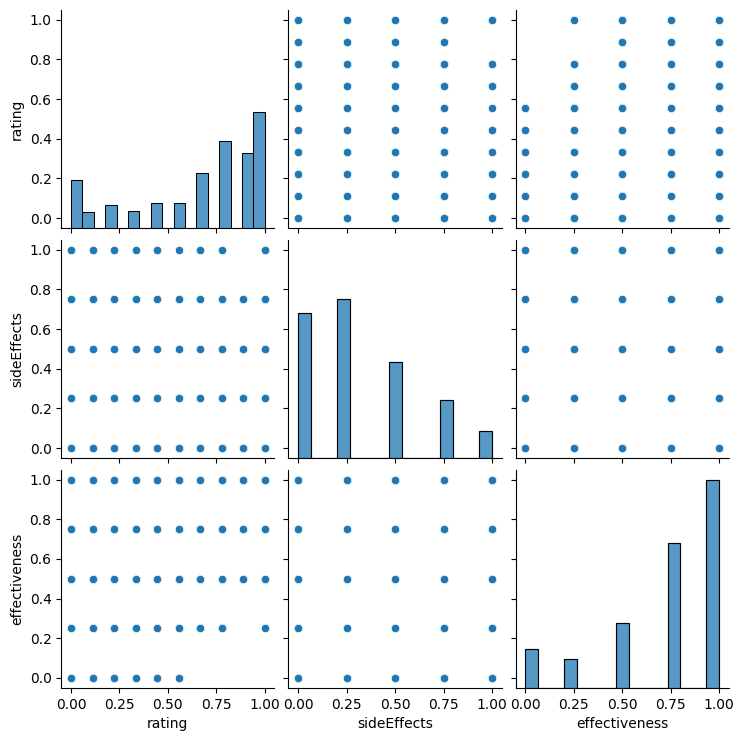

In [68]:
sns.pairplot(X)

*Del gráfico de arriba podemos observar que los medicamentos con poca efectividad o con muchos efectos secundarios, así como los que tienen poco rating, los hay en menor cantidad que sus contrapartes, esto nos indica que en general hay mas medicamentos positivos que defectuosos. Por otro lado no se ve una clusterizacion clara en 2D, es decir para pares de features tendríamos que hacer algo como:*

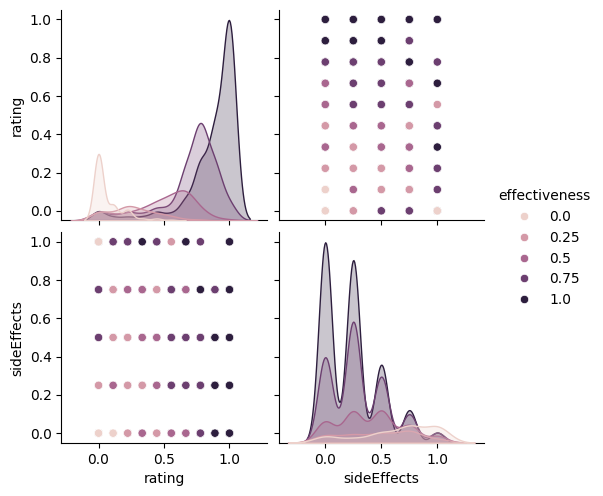

In [69]:
sns.pairplot(X, hue = "effectiveness")

*Tampoco se ve especialmente bien, pero si te fijas en el gráfico de la esquina superior derecha, los colores tienden a ser más oscuros a medida aumenta el rating y también a meida que aumenta el nivel de sideEffects, lo que habla de una relación trivariante que sí puede manifestarse en la existencia de clústeres. En la figura de abajo se sugieren dos posiblles agrupaciones de 2 o 3 clústeres visuales que no tienen por qué ser los que encuentre el modelo pero que podríamos esperar.*

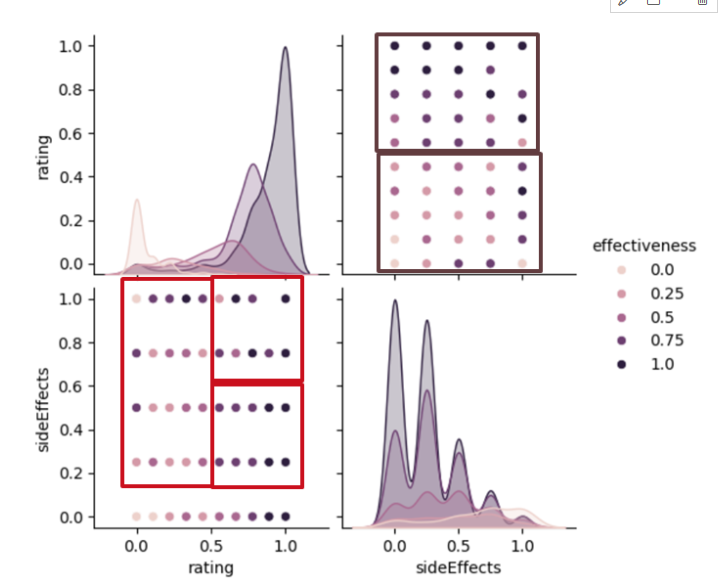

### Ejercicio 6: Obtención de K, método del codo

Evalua diferentes valores K y escoge uno a partir del método del codo/elbow de inercia.

In [70]:
#Vamos a probar con diferentes valores de k para ver cual es el mejor segun sus inercias y el metodo del codo
ks = []
inertias = []

for k in range(1, 10):
    clustering = KMeans(n_clusters = k)
    clustering.fit(X)
    inertias.append(clustering.inertia_)
    ks.append(k)

In [71]:
# Dataframe con las inercias
df_inertias = pd.DataFrame({'k': ks, 'inertia': inertias})
df_inertias

,k,inertia
0,1,893.992575
1,2,395.471897
2,3,299.907623
3,4,236.927658
4,5,188.284270
5,6,153.959304
6,7,134.390257
7,8,117.342981
8,9,104.721282


In [72]:
# Observamos qué tanto varían las inercias de una k a otra
df_inertias['diff'] = df_inertias['inertia'] - df_inertias['inertia'].shift(1)
df_inertias

,k,inertia,diff
0,1,893.992575,NaN
1,2,395.471897,-498.520678
2,3,299.907623,-95.564274
3,4,236.927658,-62.979964
4,5,188.284270,-48.643389
5,6,153.959304,-34.324966
6,7,134.390257,-19.569047
7,8,117.342981,-17.047276
8,9,104.721282,-12.621700


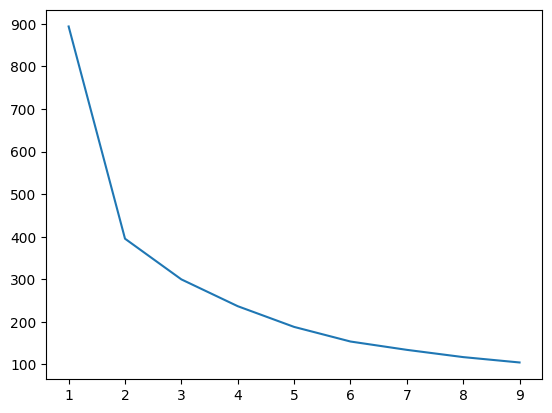

In [73]:
#Plot de las inercias agregando el cambio de 1 grupo a dos grupos
plt.plot(ks, inertias);

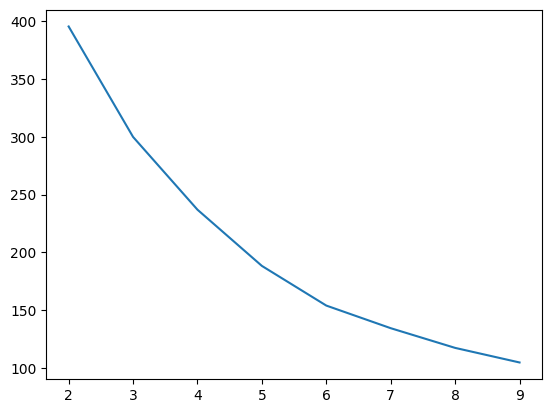

In [74]:
#Plot de inercias sin el cambio de 1 grupo a dos grupos
plt.plot(ks[1::], inertias[1::]);

*Tanto en los valores de los dataframes como en la gráfica del codo, observamos que el mayor cambio se produce entre k=1 (Todo en un grupo) y k=2 (Dos grupos), y luego se aprecia un cambio entre 2 y 3 pronunciado. El codo podría estar en $K=2$ o $K=3$ pero con un cierto nivel de duda porque tampoco se produce una desaceleración evidente de la inercia. Para confirmar la suposición K=2, K=3 acudiremos al máximo del score de silueta en el siguiente ejercicio.*

### Ejercicio 7: Obtención de K, Score de Silueta

Comprueba el ajuste de k obteniendo el k que maximiza el score de silueta y pinta un gráfico de la evolución de dicho score con k. Usa los valores de k que hayas probado en el ejercicio anterior.

In [75]:
#Calculamos el silhouette score para cada k
ks = []
sil_scores = []

for k in range(2, 10): 
    clustering = KMeans(n_clusters = k)
    clustering.fit(X)

    sil_scores.append(silhouette_score(X, clustering.labels_))
    ks.append(k)

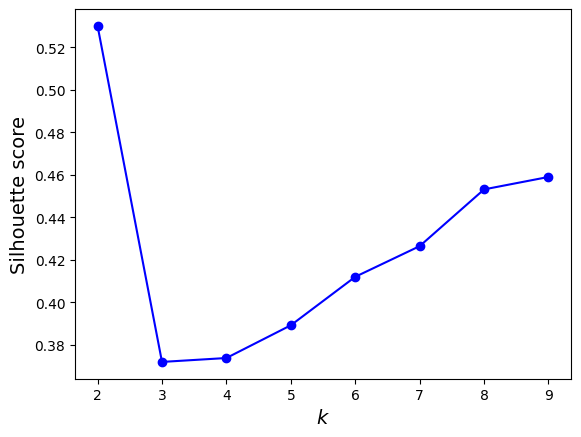

In [76]:
# Graficamos el silhouette score para cada k
plt.plot(ks, sil_scores, "bo-");
plt.xlabel("$k$", fontsize=14);
plt.ylabel("Silhouette score", fontsize=14);

*Normalmente nos interesará quedarnos con el silhouette score mas alto, en este caso es cuando utilizamos k=2, esto quiere decir que hay 2 grupos bien diferenciados entre ellos, podríamos utilizar k=3 sin embargo por ahora nos quedaremos con k=2 para facilitar el análisis posterior. En cualquier caso podríamos considerar también todavía k=3. Para terminar, acudamos al diagrama de silueta.*

### Ejercicio 8: Obtención de K, diagrama de silueta

Para completar el estudio de k, muestra el diagramde silueta para k=2,3,4,5 y decide con este datos y los anteriores el valor de k a probar. NOTA: En la realidad, podríamos probar perfectamente k=2 y k=3 y luego que "Negocio" decidiera cuál le es más útil, aquí lo completamos por practicar todo lo aprendido

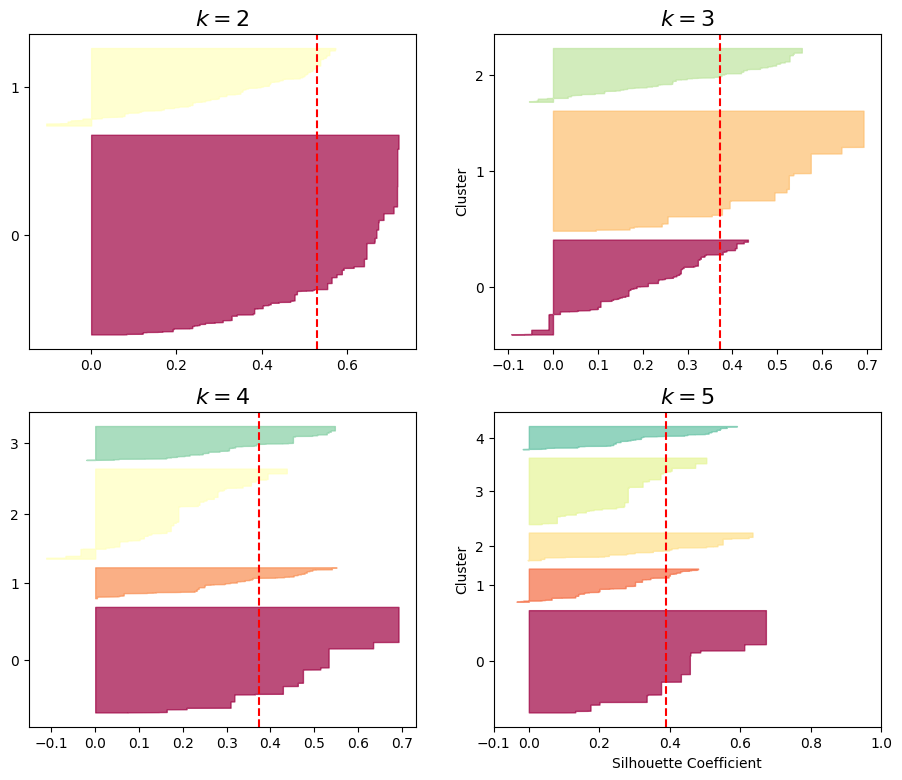

In [77]:
from matplotlib.ticker import FixedLocator, FixedFormatter

'''
La anchura de cada cuchillo representa el numero de muestras por cluster. Están ordenadas
por su coeficiente de silhouette, por eso tiene esa forma de cuchillo. Cuanta más caida tenga
indica que las muestras tienen un coeficiente mas disperso en ese cluster
Deberian estar todos los clusters por encima de la media.
Hay algunas lineas hacia la izda xq es el coeficiente negativo. Puntos asignados al cluster erroneo.
'''
plt.figure(figsize=(11, 9))

for k in (2, 3, 4, 5):
    plt.subplot(2, 2, k - 1)
    clustering = KMeans(n_clusters = k)
    clustering.fit(X)
    y_pred = clustering.labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = matplotlib.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=True)

    plt.axvline(x=sil_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)


plt.show()

*En términos de cruzar el score de silueta solo $K=4$ no cumple, $K=5$ tiene el problema de tener un score de silueta sensiblmente más bajos que para $K=2$ y $K=3$ y una distribución de clústeres desequilibrada (que no necesariamente tiene por qué ser malo). El "problemilla" de los $K=2$ y $K=3$ son esos coeficientes negativos que claramente hablan de problemas en la delimitación de los clústeres. En cualquier caso la distribución más uniforme de $K=3$ lo hace atractivo. Veredicto: Vamos a probar K=2 y K=3*

### Ejercico 9:

En general, una diferencia entre el proceso de construcción de un modelo no supervisado y un supervisado es que el ajuste de algunos hiperparámetros (como el número de clústeres) es anterior a la construcción del modelo. Por eso, construye un K-means para el valor (o valores) de K escogidos.

In [78]:
#KMeans con k = 2
clustering_k2 = KMeans(n_clusters= 2)
clustering_k2.fit(X)

KMeans(n_clusters=2)

### Ejercicio 10

Vamos a comprobar resultados, analizando los valores medios y distribución de cada uno de los clústeres para el k óptimo. Si tuvieras más de un posible valor de k a probar, analiza aquí el de mayor score de silueta. Y utiliza el siguiente ejercicio para el otro. Además de hacer un describe de las features por clúster, pinta estos con un pairplot considerando sideEffects y rating como x e y (o viceversa) y el clúster como hue (color). Compara el resultado con los clústeres sugeridos en el ejercicio 5.

In [79]:
#Kmeans con k = 2
clustering_k2 = KMeans(n_clusters= 2)
clustering_k2.fit(X)

KMeans(n_clusters=2)

In [80]:
#Creamos una nueva columna que indica el cluster asignado a cada observacion
X['cluster'] = clustering_k2.predict(X)
X.head()

,rating,sideEffects,effectiveness,cluster
0,0.333333,0.25,1.00,0
1,0.000000,0.75,1.00,1
2,1.000000,0.00,1.00,0
3,0.222222,0.25,0.25,1
4,0.111111,0.75,0.25,1


In [81]:
# Cuantos elementos hay en cada cluster
X['cluster'].value_counts(normalize= True)

cluster
0    0.720309
1    0.279691
Name: proportion, dtype: float64

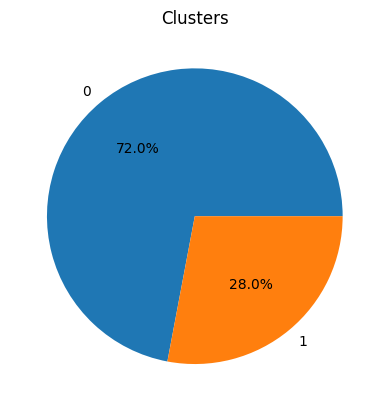

In [82]:
# Graficamos la cantidad de elementos en cada cluster
plt.pie(X['cluster'].value_counts(normalize= True), autopct= '%1.1f%%', labels= ['0', '1'])
plt.title('Clusters');

In [83]:
X.groupby('cluster').describe()

rating                                                              \
          count      mean       std  min       25%       50%       75%  max   
cluster                                                                       
0        2238.0  0.842369  0.146383  0.0  0.777778  0.888889  1.000000  1.0   
1         869.0  0.216596  0.208818  0.0  0.000000  0.222222  0.333333  1.0   

        sideEffects            ...            effectiveness            \
              count      mean  ...   75%  max         count      mean   
cluster                        ...                                      
0            2238.0  0.209674  ...  0.25  1.0        2238.0  0.868409   
1             869.0  0.626295  ...  0.75  1.0         869.0  0.387514   

                                              
              std   min   25%  50%  75%  max  
cluster                                       
0        0.164449  0.25  0.75  1.0  1.0  1.0  
1        0.319656  0.00  0.00  0.5  0.5  1.0  

[2 rows x 24 columns]

*Si observamos las estadísticas de cada columna por cada uno de los grupos, nos damos cuenta de que el cluster 0 tiene mayor cantidad de elementos, una media de rating y efectividad mas alta, así como una media de efectos secundarios mas baja que el cluster 1, esto quiere decir que estamos ante medicamentos que en general funcionan bien en el cluster 0 vs los que no en el cluster 1. Vamos a etiquetar estos grupos, llamándolos "bueno" y "malo"*

In [84]:
# cluster_map = {0: 'Good', 1: 'Bad'}
# X['Label'] = X['cluster'].map(cluster_map)
# X.head()

In [86]:
#Podemos ver la distribucion de los clusters en el espacio de las variables
sns.pairplot(data= X[['rating', 'sideEffects', 'Label']], hue= 'Label');

KeyError: "['Label'] not in index"

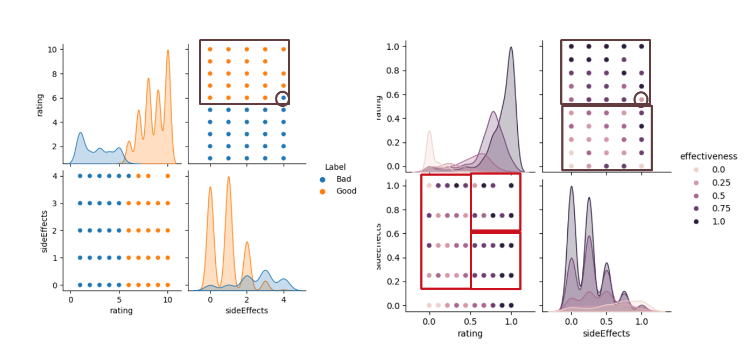

*Observa que son muy similares, incluso mejores en la captura de algún punto extremo como el indicado en la figura*

*En este ejercicio lo bonito es ver que el clustering ha encontrado unas agrupaciones con bastante sentido aunque no siempre tiene por qué ser así (ni lo será)*


### Ejercicio 11, EXTRA: Más valores de K

Repite el análisis del ejercicio 10 para un K diferente pero que consideres que tiene sentido aplicar.

In [87]:
#Kmeans con k = 3
clustering_k3 = KMeans(n_clusters= 3)
clustering_k3.fit(X)

KMeans(n_clusters=3)

In [88]:
#Creamos una nueva columna que indica el cluster asignado a cada observacion
X['cluster'] = clustering_k3.predict(X)
X.head()

,rating,sideEffects,effectiveness,cluster
0,0.333333,0.25,1.00,0
1,0.000000,0.75,1.00,1
2,1.000000,0.00,1.00,2
3,0.222222,0.25,0.25,1
4,0.111111,0.75,0.25,1


In [89]:
X.cluster.value_counts(True)


cluster
2    0.405214
0    0.315095
1    0.279691
Name: proportion, dtype: float64

In [90]:
X.groupby("cluster").describe()

rating                                                              \
          count      mean       std       min       25%       50%       75%   
cluster                                                                       
0         979.0  0.732947  0.127195  0.000000  0.666667  0.777778  0.777778   
1         869.0  0.216596  0.208818  0.000000  0.000000  0.222222  0.333333   
2        1259.0  0.927456  0.094673  0.444444  0.888889  1.000000  1.000000   

             sideEffects            ...             effectiveness            \
         max       count      mean  ...   75%   max         count      mean   
cluster                             ...                                       
0        1.0       979.0  0.357252  ...  0.50  1.00         979.0  0.769408   
1        1.0       869.0  0.626295  ...  0.75  1.00         869.0  0.387514   
2        1.0      1259.0  0.094917  ...  0.25  0.25        1259.0  0.945393   

                                               
              std   min   25%   50%  75%  max  
cluster                                        
0        0.173695  0.25  0.75  0.75  1.0  1.0  
1        0.319656  0.00  0.00  0.50  0.5  1.0  
2        0.105241  0.50  1.00  1.00  1.0  1.0  

[3 rows x 24 columns]

*Como con K=3 podemos ver una especie de "grado" o de "scoring" de valor en el cluster (cluster 0, mayores valores de rating y efectividad y menores sideEffects en media, cluster 1, un grado medio y cluster 2 el menos buenos)*

In [91]:
cluster_map = {0: 'Very Good', 1: 'Good', 2: "Bad"}

X["Label"] = X["cluster"].map(cluster_map)

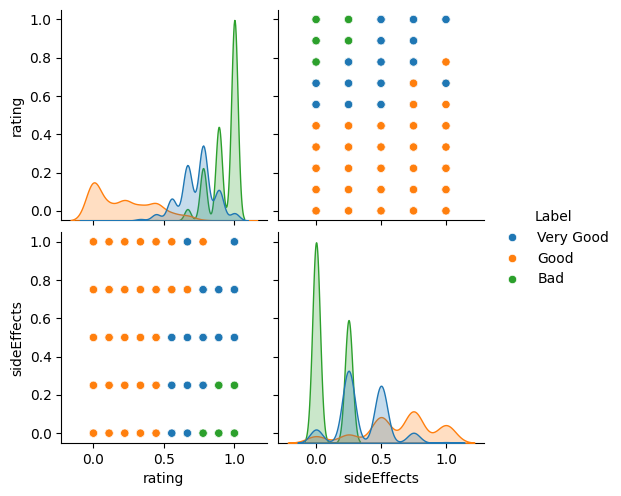

In [92]:
sns.pairplot(data = X[["Label","rating","sideEffects"]], hue = "Label")

*Comparando con el pairplot del ejercicio 5, nos daremos cuenta de que los clústeres no tienen porque tener formas regulares, e incluso que K=3 es una buena agrupación y con sentido:*

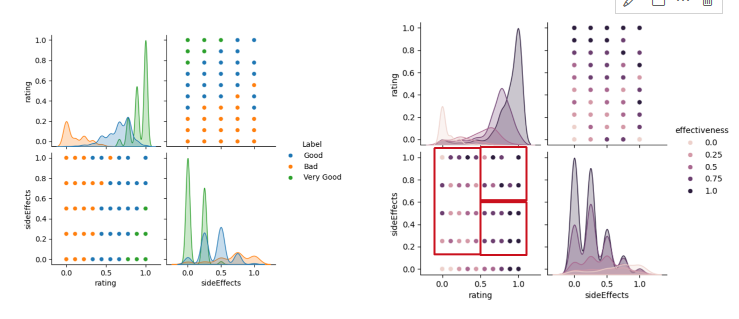